# 🧪 Experiment: Setting Combination
This notebook conducts various experiments on the combination of different settings, which includes different datasets, gazettteers, and models.

**Note**: Before conducting experiments, you need to install `kaner` package first. Otherwise, this notebook will raise an *import error*.

```bash
cd ../
python setup.py install
```

In [1]:
import os
import pprint
from typing import List
from datetime import datetime
from collections import defaultdict

import matplotlib.pyplot as plt

from kaner.pipeline import train
from kaner.context import GlobalContext as gctx
from kaner.trainer import TrainerConfig
from kaner.tracker import NERTrackerRow, NERTracker
from kaner.common.func import query_time
from kaner.common import save_json

## 1 Define `trainall` Function

In [2]:
def trainall(labpath: str, cfgdir: str, m: List[str], d: List[str], g: List[str], n: int, tag: str, **kwargs) -> NERTracker:
    """
    Conducting experiments on all settings.

    Args:
        labpath (str): The file path of recording experimental results.
        cfgdir (str): Configuration folder.
        m (List[str]): All specific models to be trained.
        d (List[str]): All specific datasets to be tested.
        g (List[str]): All specific gazetteers to be tested.
        n (int): The number of training repeating times.
        tag (str): Experimental tags.
    """

    def update_names(names: List[str], all_names: List[str], name_type: str) -> List[str]:
        """
        Check whether the name that user inputs is correct.

        Args:
            names (List[str]): The names (dataset, model, gazetteer) that user inputs.
            all_names (List[str]): All names (dataset, model, gazetteer) that this libary provides.
            name_type (str): The type of the name (Dataset, Model, Gazetteer).
        """
        if len(names) == 0:
            names = all_names
        else:
            for name in names:
                if name not in all_names:
                    print("[{0}] {1} is not in {2}".format(name_type, name, all_names))
                    exit(0)
        return names

    tracker = NERTracker.load(labpath)
    models = update_names(m, gctx.get_model_names(), "Model")
    datasets = update_names(d, gctx.get_dataset_names(), "Dataset")
    gazetteers = update_names(g, gctx.get_gazetteer_names(), "Gazetteer")

    print("--------------------- Experiment Configuration ---------------------")
    print("Models: {0}".format(models))
    print("Datasets: {0}".format(datasets))
    print("Gazetteers: {0}".format(gazetteers))
    print("--------------------------------------------------------------------")

    for dataset in datasets:
        for model in models:
            for gazetteer_model in gazetteers:
                # avoid calculation repeatly
                if model in ["blcrf", "plmtg"]:
                    gazetteer_model = "gigaword"
                for _ in range(n):
                    if len(tracker.query(dataset=dataset, model=model, gazetteer_model=gazetteer_model, tag=tag)) >= n:
                        continue
                    config = TrainerConfig(os.path.join(cfgdir, model + ".yml"), dataset=dataset, gazetteer_model=gazetteer_model, **kwargs)
                    start = str(datetime.now())
                    try:
                        results, trainer = train(config)
                    except RuntimeError as error:
                        print(error)
                        continue
                    tracker.insert(
                        NERTrackerRow(
                            start, model, dataset, config.tokenizer_model, gazetteer_model, config.output_folder, query_time(trainer.train),
                            results["f1-score"], results["precision-score"], results["recall-score"], results["epoch_count"], results["test-loss"], tag
                        )
                    )
                    tracker.save(labpath)
                    del trainer

    return tracker

## 2 Given models, datasets, gazetteers, train them
You can find all available models, datasets and gazetteers by the following code block.

```python
models = gctx.get_model_names()
datasets = gctx.get_dataset_names()
gazetteers = gctx.get_gazetteer_names()
```

In [ ]:
labpath = "../data/logs/experiments_tec.csv"
cfgdir = "../configs"
models = ["ses", "cgn", "mdgg"]
datasets = ["weiboner", "resumener", "ecommerce", "msraner", "ontonotes"]
gazetteers = ["tec"]
n = 5
tag = "nil"
kwargs = {"data_folder": "../data", "gpu": [1]}

trainall(labpath, cfgdir, models, datasets, gazetteers, n, tag, **kwargs)

--------------------- Experiment Configuration ---------------------
Models: ['ses', 'cgn', 'mdgg']
Datasets: ['weiboner', 'resumener', 'ecommerce', 'msraner', 'ontonotes']
Gazetteers: ['tec']
--------------------------------------------------------------------
[Dataset: ../data/datahub/weiboner] 1350 train, 270 dev, 270 test. (resplit: False)
Lexicon embedding is None! ../data/modelhub/tec


2020-09-30 03:35:48 [ses, weiboner] epoch: 0, no_improvement: 0, dev-f1: 0.00506, dev-precision: 0.16667, dev-recall: 0.00257, dev-loss: 13.33458, train-loss: 23.97319
2020-09-30 03:35:55 [ses, weiboner] epoch: 1, no_improvement: 0, dev-f1: 0.33826, dev-precision: 0.46818, dev-recall: 0.26478, dev-loss: 9.40883, train-loss: 12.48706
2020-09-30 03:36:01 [ses, weiboner] epoch: 2, no_improvement: 0, dev-f1: 0.45087, dev-precision: 0.51485, dev-recall: 0.40103, dev-loss: 7.43364, train-loss: 8.09259
2020-09-30 03:36:08 [ses, weiboner] epoch: 3, no_improvement: 0, dev-f1: 0.51768, dev-precision: 0.57547, dev-recall: 0.47044, dev-loss: 6.71188, train-loss: 5.20813
2020-09-30 03:36:14 [ses, weiboner] epoch: 4, no_improvement: 0, dev-f1: 0.51774, dev-precision: 0.52957, dev-recall: 0.50643, dev-loss: 7.78891, train-loss: 3.28556
2020-09-30 03:36:20 [ses, weiboner] epoch: 5, no_improvement: 1, dev-f1: 0.43699, dev-precision: 0.39706, dev-recall: 0.48586, dev-loss: 9.11298, train-loss: 2.42965
2

[Timing] kaner.trainer.base.train function took 240.698 sec
# Save experimental data into ../data/logs/experiments_tec.csv
[Dataset: ../data/datahub/weiboner] 1350 train, 270 dev, 270 test. (resplit: False)
Lexicon embedding is None! ../data/modelhub/tec


2020-09-30 03:39:51 [ses, weiboner] epoch: 0, no_improvement: 0, dev-f1: 0.15517, dev-precision: 0.48, dev-recall: 0.09254, dev-loss: 11.51734, train-loss: 21.13028
2020-09-30 03:39:57 [ses, weiboner] epoch: 1, no_improvement: 0, dev-f1: 0.4239, dev-precision: 0.47452, dev-recall: 0.38303, dev-loss: 8.07879, train-loss: 10.17566
2020-09-30 03:40:04 [ses, weiboner] epoch: 2, no_improvement: 0, dev-f1: 0.47682, dev-precision: 0.4918, dev-recall: 0.46272, dev-loss: 7.17894, train-loss: 6.33409
2020-09-30 03:40:10 [ses, weiboner] epoch: 3, no_improvement: 0, dev-f1: 0.51881, dev-precision: 0.52356, dev-recall: 0.51414, dev-loss: 7.79118, train-loss: 3.97494
2020-09-30 03:40:16 [ses, weiboner] epoch: 4, no_improvement: 0, dev-f1: 0.54572, dev-precision: 0.62667, dev-recall: 0.48329, dev-loss: 7.8107, train-loss: 2.72142
2020-09-30 03:40:23 [ses, weiboner] epoch: 5, no_improvement: 1, dev-f1: 0.51299, dev-precision: 0.69604, dev-recall: 0.40617, dev-loss: 11.42295, train-loss: 2.41826
2020-0

[Timing] kaner.trainer.base.train function took 187.083 sec
# Save experimental data into ../data/logs/experiments_tec.csv
[Dataset: ../data/datahub/weiboner] 1350 train, 270 dev, 270 test. (resplit: False)
Lexicon embedding is None! ../data/modelhub/tec


2020-09-30 03:43:01 [ses, weiboner] epoch: 0, no_improvement: 0, dev-f1: 0.01, dev-precision: 0.18182, dev-recall: 0.00514, dev-loss: 13.04915, train-loss: 23.72266
2020-09-30 03:43:07 [ses, weiboner] epoch: 1, no_improvement: 0, dev-f1: 0.37004, dev-precision: 0.43151, dev-recall: 0.32391, dev-loss: 9.08842, train-loss: 11.96098
2020-09-30 03:43:14 [ses, weiboner] epoch: 2, no_improvement: 0, dev-f1: 0.45911, dev-precision: 0.51948, dev-recall: 0.41131, dev-loss: 7.32377, train-loss: 7.7495
2020-09-30 03:43:20 [ses, weiboner] epoch: 3, no_improvement: 0, dev-f1: 0.48974, dev-precision: 0.52339, dev-recall: 0.46015, dev-loss: 7.03274, train-loss: 4.96347
2020-09-30 03:43:26 [ses, weiboner] epoch: 4, no_improvement: 1, dev-f1: 0.47927, dev-precision: 0.48303, dev-recall: 0.47558, dev-loss: 7.94775, train-loss: 3.27031
2020-09-30 03:43:33 [ses, weiboner] epoch: 5, no_improvement: 2, dev-f1: 0.46495, dev-precision: 0.42612, dev-recall: 0.51157, dev-loss: 8.45239, train-loss: 2.41997
2020-

[Timing] kaner.trainer.base.train function took 192.748 sec
# Save experimental data into ../data/logs/experiments_tec.csv
[Dataset: ../data/datahub/weiboner] 1350 train, 270 dev, 270 test. (resplit: False)
Lexicon embedding is None! ../data/modelhub/tec


2020-09-30 03:46:16 [ses, weiboner] epoch: 0, no_improvement: 0, dev-f1: 0.08607, dev-precision: 0.21212, dev-recall: 0.05398, dev-loss: 11.85005, train-loss: 21.2946
2020-09-30 03:46:23 [ses, weiboner] epoch: 1, no_improvement: 0, dev-f1: 0.39548, dev-precision: 0.43887, dev-recall: 0.3599, dev-loss: 8.11549, train-loss: 10.28001
2020-09-30 03:46:29 [ses, weiboner] epoch: 2, no_improvement: 0, dev-f1: 0.51499, dev-precision: 0.54783, dev-recall: 0.48586, dev-loss: 7.11071, train-loss: 6.58342
2020-09-30 03:46:35 [ses, weiboner] epoch: 3, no_improvement: 1, dev-f1: 0.45721, dev-precision: 0.4359, dev-recall: 0.48072, dev-loss: 7.4653, train-loss: 4.0636
2020-09-30 03:46:42 [ses, weiboner] epoch: 4, no_improvement: 0, dev-f1: 0.52162, dev-precision: 0.54986, dev-recall: 0.49614, dev-loss: 8.58174, train-loss: 2.71663
2020-09-30 03:46:48 [ses, weiboner] epoch: 5, no_improvement: 0, dev-f1: 0.54674, dev-precision: 0.60883, dev-recall: 0.49614, dev-loss: 8.56895, train-loss: 2.26541
2020-0

[Timing] kaner.trainer.base.train function took 135.945 sec
# Save experimental data into ../data/logs/experiments_tec.csv
[Dataset: ../data/datahub/weiboner] 1350 train, 270 dev, 270 test. (resplit: False)
Lexicon embedding is None! ../data/modelhub/tec


2020-09-30 03:48:35 [ses, weiboner] epoch: 0, no_improvement: 0, dev-f1: 0.2004, dev-precision: 0.45455, dev-recall: 0.12853, dev-loss: 11.72316, train-loss: 21.19452
2020-09-30 03:48:41 [ses, weiboner] epoch: 1, no_improvement: 0, dev-f1: 0.37925, dev-precision: 0.51316, dev-recall: 0.30077, dev-loss: 8.60884, train-loss: 10.6458
2020-09-30 03:48:48 [ses, weiboner] epoch: 2, no_improvement: 0, dev-f1: 0.50294, dev-precision: 0.58763, dev-recall: 0.43959, dev-loss: 7.52877, train-loss: 6.86519
2020-09-30 03:48:54 [ses, weiboner] epoch: 3, no_improvement: 0, dev-f1: 0.52308, dev-precision: 0.57362, dev-recall: 0.48072, dev-loss: 7.34939, train-loss: 4.31317
2020-09-30 03:49:01 [ses, weiboner] epoch: 4, no_improvement: 1, dev-f1: 0.52055, dev-precision: 0.55718, dev-recall: 0.48843, dev-loss: 8.22224, train-loss: 2.66624
2020-09-30 03:49:07 [ses, weiboner] epoch: 5, no_improvement: 2, dev-f1: 0.4918, dev-precision: 0.52478, dev-recall: 0.46272, dev-loss: 9.05839, train-loss: 1.89684
2020

[Timing] kaner.trainer.base.train function took 265.695 sec
# Save experimental data into ../data/logs/experiments_tec.csv
[Dataset: ../data/datahub/weiboner] 1350 train, 270 dev, 270 test. (resplit: False)
Lexicon embedding is None! ../data/modelhub/tec


2020-09-30 03:53:24 [cgn, weiboner] epoch: 0, no_improvement: 0, dev-f1: 0.26307, dev-precision: 0.34298, dev-recall: 0.21337, dev-loss: 10.00975, train-loss: 16.32441
2020-09-30 03:53:53 [cgn, weiboner] epoch: 1, no_improvement: 0, dev-f1: 0.38353, dev-precision: 0.38402, dev-recall: 0.38303, dev-loss: 9.17461, train-loss: 8.61477
2020-09-30 03:54:21 [cgn, weiboner] epoch: 2, no_improvement: 0, dev-f1: 0.45939, dev-precision: 0.45363, dev-recall: 0.4653, dev-loss: 9.55978, train-loss: 5.61866
2020-09-30 03:54:50 [cgn, weiboner] epoch: 3, no_improvement: 0, dev-f1: 0.47891, dev-precision: 0.50867, dev-recall: 0.45244, dev-loss: 10.31337, train-loss: 3.70295
2020-09-30 03:55:19 [cgn, weiboner] epoch: 4, no_improvement: 1, dev-f1: 0.44893, dev-precision: 0.44059, dev-recall: 0.45758, dev-loss: 11.52705, train-loss: 2.81074
2020-09-30 03:55:47 [cgn, weiboner] epoch: 5, no_improvement: 0, dev-f1: 0.49396, dev-precision: 0.51685, dev-recall: 0.47301, dev-loss: 11.81435, train-loss: 2.18853


[Timing] kaner.trainer.base.train function took 895.870 sec
# Save experimental data into ../data/logs/experiments_tec.csv
[Dataset: ../data/datahub/weiboner] 1350 train, 270 dev, 270 test. (resplit: False)
Lexicon embedding is None! ../data/modelhub/tec


2020-09-30 04:08:23 [cgn, weiboner] epoch: 0, no_improvement: 0, dev-f1: 0.27928, dev-precision: 0.33574, dev-recall: 0.23907, dev-loss: 9.87982, train-loss: 16.14717
2020-09-30 04:08:51 [cgn, weiboner] epoch: 1, no_improvement: 0, dev-f1: 0.44129, dev-precision: 0.44301, dev-recall: 0.43959, dev-loss: 8.76951, train-loss: 8.47734
2020-09-30 04:09:20 [cgn, weiboner] epoch: 2, no_improvement: 0, dev-f1: 0.49123, dev-precision: 0.51705, dev-recall: 0.46787, dev-loss: 8.78023, train-loss: 5.51297
2020-09-30 04:09:48 [cgn, weiboner] epoch: 3, no_improvement: 0, dev-f1: 0.5, dev-precision: 0.5403, dev-recall: 0.4653, dev-loss: 9.91596, train-loss: 3.46178
2020-09-30 04:10:17 [cgn, weiboner] epoch: 4, no_improvement: 1, dev-f1: 0.43137, dev-precision: 0.41218, dev-recall: 0.45244, dev-loss: 12.68411, train-loss: 2.65294
2020-09-30 04:10:47 [cgn, weiboner] epoch: 5, no_improvement: 2, dev-f1: 0.49243, dev-precision: 0.52959, dev-recall: 0.46015, dev-loss: 11.93337, train-loss: 2.3497
2020-09-

[Timing] kaner.trainer.base.train function took 1200.162 sec
# Save experimental data into ../data/logs/experiments_tec.csv
[Dataset: ../data/datahub/weiboner] 1350 train, 270 dev, 270 test. (resplit: False)
Lexicon embedding is None! ../data/modelhub/tec


2020-09-30 04:28:24 [cgn, weiboner] epoch: 0, no_improvement: 0, dev-f1: 0.25592, dev-precision: 0.33197, dev-recall: 0.20823, dev-loss: 9.97722, train-loss: 16.38369
2020-09-30 04:28:53 [cgn, weiboner] epoch: 1, no_improvement: 0, dev-f1: 0.44183, dev-precision: 0.44947, dev-recall: 0.43445, dev-loss: 9.32875, train-loss: 8.45953
2020-09-30 04:29:21 [cgn, weiboner] epoch: 2, no_improvement: 0, dev-f1: 0.46433, dev-precision: 0.43836, dev-recall: 0.49357, dev-loss: 9.59809, train-loss: 5.40056
2020-09-30 04:29:50 [cgn, weiboner] epoch: 3, no_improvement: 1, dev-f1: 0.44301, dev-precision: 0.44648, dev-recall: 0.43959, dev-loss: 10.05976, train-loss: 3.5636
2020-09-30 04:30:19 [cgn, weiboner] epoch: 4, no_improvement: 0, dev-f1: 0.49176, dev-precision: 0.52802, dev-recall: 0.46015, dev-loss: 10.89985, train-loss: 3.01037
2020-09-30 04:30:48 [cgn, weiboner] epoch: 5, no_improvement: 1, dev-f1: 0.47361, dev-precision: 0.53205, dev-recall: 0.42674, dev-loss: 11.39977, train-loss: 2.56927
2

[Timing] kaner.trainer.base.train function took 821.294 sec
# Save experimental data into ../data/logs/experiments_tec.csv
[Dataset: ../data/datahub/weiboner] 1350 train, 270 dev, 270 test. (resplit: False)
Lexicon embedding is None! ../data/modelhub/tec


2020-09-30 04:42:07 [cgn, weiboner] epoch: 0, no_improvement: 0, dev-f1: 0.28399, dev-precision: 0.34432, dev-recall: 0.24165, dev-loss: 10.033, train-loss: 16.30609
2020-09-30 04:42:35 [cgn, weiboner] epoch: 1, no_improvement: 0, dev-f1: 0.3949, dev-precision: 0.39141, dev-recall: 0.39846, dev-loss: 9.19592, train-loss: 8.34635
2020-09-30 04:43:04 [cgn, weiboner] epoch: 2, no_improvement: 0, dev-f1: 0.44675, dev-precision: 0.45144, dev-recall: 0.44216, dev-loss: 9.64224, train-loss: 5.38113
2020-09-30 04:43:33 [cgn, weiboner] epoch: 3, no_improvement: 0, dev-f1: 0.47091, dev-precision: 0.49714, dev-recall: 0.4473, dev-loss: 10.6275, train-loss: 3.40809
2020-09-30 04:44:04 [cgn, weiboner] epoch: 4, no_improvement: 1, dev-f1: 0.44037, dev-precision: 0.4492, dev-recall: 0.43188, dev-loss: 11.20772, train-loss: 2.94866
2020-09-30 04:44:34 [cgn, weiboner] epoch: 5, no_improvement: 0, dev-f1: 0.51403, dev-precision: 0.60417, dev-recall: 0.4473, dev-loss: 12.64049, train-loss: 2.11447
2020-0

[Timing] kaner.trainer.base.train function took 1233.803 sec
# Save experimental data into ../data/logs/experiments_tec.csv
[Dataset: ../data/datahub/weiboner] 1350 train, 270 dev, 270 test. (resplit: False)
Lexicon embedding is None! ../data/modelhub/tec


2020-09-30 05:02:42 [cgn, weiboner] epoch: 0, no_improvement: 0, dev-f1: 0.29641, dev-precision: 0.35484, dev-recall: 0.2545, dev-loss: 9.77986, train-loss: 15.96717
2020-09-30 05:03:11 [cgn, weiboner] epoch: 1, no_improvement: 0, dev-f1: 0.40316, dev-precision: 0.41351, dev-recall: 0.39332, dev-loss: 8.64441, train-loss: 8.53122
2020-09-30 05:03:40 [cgn, weiboner] epoch: 2, no_improvement: 0, dev-f1: 0.46512, dev-precision: 0.46753, dev-recall: 0.46272, dev-loss: 9.28936, train-loss: 5.59879
2020-09-30 05:04:09 [cgn, weiboner] epoch: 3, no_improvement: 0, dev-f1: 0.48183, dev-precision: 0.50565, dev-recall: 0.46015, dev-loss: 9.72267, train-loss: 3.65151
2020-09-30 05:04:38 [cgn, weiboner] epoch: 4, no_improvement: 1, dev-f1: 0.4395, dev-precision: 0.47879, dev-recall: 0.40617, dev-loss: 10.67706, train-loss: 2.95172
2020-09-30 05:05:07 [cgn, weiboner] epoch: 5, no_improvement: 0, dev-f1: 0.5014, dev-precision: 0.55077, dev-recall: 0.46015, dev-loss: 12.49088, train-loss: 2.5173
2020-

[Timing] kaner.trainer.base.train function took 846.977 sec
# Save experimental data into ../data/logs/experiments_tec.csv
[Dataset: ../data/datahub/weiboner] 1350 train, 270 dev, 270 test. (resplit: False)
Lexicon embedding is None! ../data/modelhub/tec


2020-09-30 05:17:19 [mdgg, weiboner] epoch: 0, no_improvement: 0, dev-f1: 0.21244, dev-precision: 0.25926, dev-recall: 0.17995, dev-loss: 10.83068, train-loss: 17.68267
2020-09-30 05:17:58 [mdgg, weiboner] epoch: 1, no_improvement: 0, dev-f1: 0.36103, dev-precision: 0.40777, dev-recall: 0.32391, dev-loss: 8.98895, train-loss: 12.24638
2020-09-30 05:18:36 [mdgg, weiboner] epoch: 2, no_improvement: 0, dev-f1: 0.43916, dev-precision: 0.4816, dev-recall: 0.4036, dev-loss: 8.26923, train-loss: 10.69261
2020-09-30 05:19:15 [mdgg, weiboner] epoch: 3, no_improvement: 0, dev-f1: 0.48859, dev-precision: 0.51124, dev-recall: 0.46787, dev-loss: 7.73328, train-loss: 9.58597
2020-09-30 05:19:54 [mdgg, weiboner] epoch: 4, no_improvement: 0, dev-f1: 0.50388, dev-precision: 0.50649, dev-recall: 0.50129, dev-loss: 7.50393, train-loss: 8.63785
2020-09-30 05:20:33 [mdgg, weiboner] epoch: 5, no_improvement: 0, dev-f1: 0.51064, dev-precision: 0.49756, dev-recall: 0.52442, dev-loss: 7.43568, train-loss: 8.10

[Timing] kaner.trainer.base.train function took 1887.111 sec
# Save experimental data into ../data/logs/experiments_tec.csv
[Dataset: ../data/datahub/weiboner] 1350 train, 270 dev, 270 test. (resplit: False)
Lexicon embedding is None! ../data/modelhub/tec


2020-09-30 05:49:03 [mdgg, weiboner] epoch: 0, no_improvement: 0, dev-f1: 0.21021, dev-precision: 0.25271, dev-recall: 0.17995, dev-loss: 11.33972, train-loss: 18.04456
2020-09-30 05:49:41 [mdgg, weiboner] epoch: 1, no_improvement: 0, dev-f1: 0.36158, dev-precision: 0.40125, dev-recall: 0.32905, dev-loss: 9.66036, train-loss: 12.36645
2020-09-30 05:50:19 [mdgg, weiboner] epoch: 2, no_improvement: 0, dev-f1: 0.38965, dev-precision: 0.41449, dev-recall: 0.36761, dev-loss: 8.76697, train-loss: 11.0007
2020-09-30 05:50:58 [mdgg, weiboner] epoch: 3, no_improvement: 0, dev-f1: 0.46676, dev-precision: 0.49425, dev-recall: 0.44216, dev-loss: 8.16247, train-loss: 9.95273
2020-09-30 05:51:36 [mdgg, weiboner] epoch: 4, no_improvement: 0, dev-f1: 0.48429, dev-precision: 0.49333, dev-recall: 0.47558, dev-loss: 8.01977, train-loss: 8.91692
2020-09-30 05:52:14 [mdgg, weiboner] epoch: 5, no_improvement: 0, dev-f1: 0.5245, dev-precision: 0.54098, dev-recall: 0.509, dev-loss: 7.32545, train-loss: 8.2728

[Timing] kaner.trainer.base.train function took 1932.842 sec
# Save experimental data into ../data/logs/experiments_tec.csv
[Dataset: ../data/datahub/weiboner] 1350 train, 270 dev, 270 test. (resplit: False)
Lexicon embedding is None! ../data/modelhub/tec


2020-09-30 06:21:34 [mdgg, weiboner] epoch: 0, no_improvement: 0, dev-f1: 0.08108, dev-precision: 0.11823, dev-recall: 0.0617, dev-loss: 11.35061, train-loss: 18.50317
2020-09-30 06:22:12 [mdgg, weiboner] epoch: 1, no_improvement: 0, dev-f1: 0.39517, dev-precision: 0.4781, dev-recall: 0.33676, dev-loss: 9.14704, train-loss: 12.55609
2020-09-30 06:22:50 [mdgg, weiboner] epoch: 2, no_improvement: 0, dev-f1: 0.42857, dev-precision: 0.45042, dev-recall: 0.40874, dev-loss: 8.42269, train-loss: 10.84539
2020-09-30 06:23:28 [mdgg, weiboner] epoch: 3, no_improvement: 0, dev-f1: 0.47059, dev-precision: 0.47872, dev-recall: 0.46272, dev-loss: 7.82609, train-loss: 9.80043
2020-09-30 06:24:06 [mdgg, weiboner] epoch: 4, no_improvement: 0, dev-f1: 0.47273, dev-precision: 0.47769, dev-recall: 0.46787, dev-loss: 7.54798, train-loss: 8.94383
2020-09-30 06:24:44 [mdgg, weiboner] epoch: 5, no_improvement: 0, dev-f1: 0.49242, dev-precision: 0.48387, dev-recall: 0.50129, dev-loss: 7.45457, train-loss: 8.35

[Timing] kaner.trainer.base.train function took 1687.559 sec
# Save experimental data into ../data/logs/experiments_tec.csv
[Dataset: ../data/datahub/weiboner] 1350 train, 270 dev, 270 test. (resplit: False)
Lexicon embedding is None! ../data/modelhub/tec


2020-09-30 06:50:01 [mdgg, weiboner] epoch: 0, no_improvement: 0, dev-f1: 0.23973, dev-precision: 0.35897, dev-recall: 0.17995, dev-loss: 11.20372, train-loss: 18.22729
2020-09-30 06:50:39 [mdgg, weiboner] epoch: 1, no_improvement: 0, dev-f1: 0.37318, dev-precision: 0.43098, dev-recall: 0.32905, dev-loss: 9.16021, train-loss: 12.45686
2020-09-30 06:51:17 [mdgg, weiboner] epoch: 2, no_improvement: 0, dev-f1: 0.46328, dev-precision: 0.51411, dev-recall: 0.42159, dev-loss: 8.18531, train-loss: 10.90834
2020-09-30 06:51:55 [mdgg, weiboner] epoch: 3, no_improvement: 0, dev-f1: 0.47802, dev-precision: 0.51327, dev-recall: 0.4473, dev-loss: 7.73813, train-loss: 9.74478
2020-09-30 06:52:34 [mdgg, weiboner] epoch: 4, no_improvement: 0, dev-f1: 0.49103, dev-precision: 0.52976, dev-recall: 0.45758, dev-loss: 7.39962, train-loss: 8.87166
2020-09-30 06:53:12 [mdgg, weiboner] epoch: 5, no_improvement: 1, dev-f1: 0.47727, dev-precision: 0.46898, dev-recall: 0.48586, dev-loss: 7.6525, train-loss: 8.19

[Timing] kaner.trainer.base.train function took 1915.462 sec
# Save experimental data into ../data/logs/experiments_tec.csv
[Dataset: ../data/datahub/weiboner] 1350 train, 270 dev, 270 test. (resplit: False)
Lexicon embedding is None! ../data/modelhub/tec


2020-09-30 07:22:15 [mdgg, weiboner] epoch: 0, no_improvement: 0, dev-f1: 0.19355, dev-precision: 0.25974, dev-recall: 0.15424, dev-loss: 11.1371, train-loss: 18.28618
2020-09-30 07:22:53 [mdgg, weiboner] epoch: 1, no_improvement: 0, dev-f1: 0.36888, dev-precision: 0.41967, dev-recall: 0.32905, dev-loss: 9.27532, train-loss: 12.68238
2020-09-30 07:23:32 [mdgg, weiboner] epoch: 2, no_improvement: 0, dev-f1: 0.44196, dev-precision: 0.48466, dev-recall: 0.40617, dev-loss: 8.36655, train-loss: 10.86568
2020-09-30 07:24:12 [mdgg, weiboner] epoch: 3, no_improvement: 0, dev-f1: 0.48257, dev-precision: 0.5042, dev-recall: 0.46272, dev-loss: 7.84462, train-loss: 9.81832
2020-09-30 07:24:50 [mdgg, weiboner] epoch: 4, no_improvement: 0, dev-f1: 0.52185, dev-precision: 0.53825, dev-recall: 0.50643, dev-loss: 7.57744, train-loss: 8.97131
2020-09-30 07:25:29 [mdgg, weiboner] epoch: 5, no_improvement: 1, dev-f1: 0.4956, dev-precision: 0.48522, dev-recall: 0.50643, dev-loss: 7.5635, train-loss: 8.2206

[Timing] kaner.trainer.base.train function took 1490.747 sec
# Save experimental data into ../data/logs/experiments_tec.csv
[Dataset: ../data/datahub/resumener] 3821 train, 463 dev, 477 test. (resplit: False)
Lexicon embedding is None! ../data/modelhub/tec


2020-09-30 07:46:47 [ses, resumener] epoch: 0, no_improvement: 0, dev-f1: 0.85606, dev-precision: 0.87782, dev-recall: 0.83535, dev-loss: 4.22495, train-loss: 15.36112
2020-09-30 07:47:01 [ses, resumener] epoch: 1, no_improvement: 0, dev-f1: 0.89648, dev-precision: 0.89379, dev-recall: 0.89919, dev-loss: 2.76249, train-loss: 3.17376
2020-09-30 07:47:15 [ses, resumener] epoch: 2, no_improvement: 0, dev-f1: 0.90786, dev-precision: 0.91186, dev-recall: 0.9039, dev-loss: 2.46084, train-loss: 1.8181
2020-09-30 07:47:29 [ses, resumener] epoch: 3, no_improvement: 1, dev-f1: 0.89841, dev-precision: 0.90237, dev-recall: 0.89449, dev-loss: 2.55179, train-loss: 1.15431
2020-09-30 07:47:43 [ses, resumener] epoch: 4, no_improvement: 2, dev-f1: 0.90333, dev-precision: 0.89616, dev-recall: 0.91062, dev-loss: 2.73318, train-loss: 0.94276
2020-09-30 07:47:57 [ses, resumener] epoch: 5, no_improvement: 0, dev-f1: 0.90982, dev-precision: 0.90769, dev-recall: 0.91196, dev-loss: 2.47951, train-loss: 0.82294

[Timing] kaner.trainer.base.train function took 286.353 sec
# Save experimental data into ../data/logs/experiments_tec.csv
[Dataset: ../data/datahub/resumener] 3821 train, 463 dev, 477 test. (resplit: False)
Lexicon embedding is None! ../data/modelhub/tec


2020-09-30 07:51:37 [ses, resumener] epoch: 0, no_improvement: 0, dev-f1: 0.85772, dev-precision: 0.86685, dev-recall: 0.84879, dev-loss: 4.09884, train-loss: 17.58961
2020-09-30 07:51:51 [ses, resumener] epoch: 1, no_improvement: 0, dev-f1: 0.89143, dev-precision: 0.89173, dev-recall: 0.89113, dev-loss: 3.16967, train-loss: 3.47664
2020-09-30 07:52:05 [ses, resumener] epoch: 2, no_improvement: 0, dev-f1: 0.90077, dev-precision: 0.89568, dev-recall: 0.90591, dev-loss: 2.91562, train-loss: 2.0557
2020-09-30 07:52:19 [ses, resumener] epoch: 3, no_improvement: 0, dev-f1: 0.91128, dev-precision: 0.90794, dev-recall: 0.91465, dev-loss: 2.65883, train-loss: 1.3916
2020-09-30 07:52:33 [ses, resumener] epoch: 4, no_improvement: 1, dev-f1: 0.90609, dev-precision: 0.90762, dev-recall: 0.90457, dev-loss: 3.00398, train-loss: 0.98967
2020-09-30 07:52:47 [ses, resumener] epoch: 5, no_improvement: 2, dev-f1: 0.90763, dev-precision: 0.90732, dev-recall: 0.90793, dev-loss: 3.40883, train-loss: 0.8523


[Timing] kaner.trainer.base.train function took 284.915 sec
# Save experimental data into ../data/logs/experiments_tec.csv
[Dataset: ../data/datahub/resumener] 3821 train, 463 dev, 477 test. (resplit: False)
Lexicon embedding is None! ../data/modelhub/tec


2020-09-30 07:56:24 [ses, resumener] epoch: 0, no_improvement: 0, dev-f1: 0.85656, dev-precision: 0.86657, dev-recall: 0.84677, dev-loss: 3.92472, train-loss: 17.86599
2020-09-30 07:56:39 [ses, resumener] epoch: 1, no_improvement: 0, dev-f1: 0.88043, dev-precision: 0.88251, dev-recall: 0.87836, dev-loss: 2.82538, train-loss: 3.36704
2020-09-30 07:56:53 [ses, resumener] epoch: 2, no_improvement: 0, dev-f1: 0.90312, dev-precision: 0.91052, dev-recall: 0.89583, dev-loss: 2.62466, train-loss: 1.95919
2020-09-30 07:57:08 [ses, resumener] epoch: 3, no_improvement: 0, dev-f1: 0.9064, dev-precision: 0.90823, dev-recall: 0.90457, dev-loss: 2.59457, train-loss: 1.38594
2020-09-30 07:57:22 [ses, resumener] epoch: 4, no_improvement: 0, dev-f1: 0.91117, dev-precision: 0.9124, dev-recall: 0.90995, dev-loss: 2.34795, train-loss: 0.91552
2020-09-30 07:57:37 [ses, resumener] epoch: 5, no_improvement: 1, dev-f1: 0.90262, dev-precision: 0.90201, dev-recall: 0.90323, dev-loss: 3.16783, train-loss: 0.72206

[Timing] kaner.trainer.base.train function took 278.877 sec
# Save experimental data into ../data/logs/experiments_tec.csv
[Dataset: ../data/datahub/resumener] 3821 train, 463 dev, 477 test. (resplit: False)
Lexicon embedding is None! ../data/modelhub/tec


2020-09-30 08:01:07 [ses, resumener] epoch: 0, no_improvement: 0, dev-f1: 0.85384, dev-precision: 0.86382, dev-recall: 0.84409, dev-loss: 4.18903, train-loss: 16.15041
2020-09-30 08:01:21 [ses, resumener] epoch: 1, no_improvement: 0, dev-f1: 0.89502, dev-precision: 0.89623, dev-recall: 0.89382, dev-loss: 3.06733, train-loss: 3.36654
2020-09-30 08:01:35 [ses, resumener] epoch: 2, no_improvement: 0, dev-f1: 0.90682, dev-precision: 0.91113, dev-recall: 0.90255, dev-loss: 2.69121, train-loss: 1.87257
2020-09-30 08:01:49 [ses, resumener] epoch: 3, no_improvement: 1, dev-f1: 0.90502, dev-precision: 0.9008, dev-recall: 0.90927, dev-loss: 3.10083, train-loss: 1.17078
2020-09-30 08:02:03 [ses, resumener] epoch: 4, no_improvement: 0, dev-f1: 0.90811, dev-precision: 0.91304, dev-recall: 0.90323, dev-loss: 3.0774, train-loss: 1.01884
2020-09-30 08:02:17 [ses, resumener] epoch: 5, no_improvement: 0, dev-f1: 0.91079, dev-precision: 0.90237, dev-recall: 0.91935, dev-loss: 2.60738, train-loss: 1.10808

[Timing] kaner.trainer.base.train function took 257.808 sec
# Save experimental data into ../data/logs/experiments_tec.csv
[Dataset: ../data/datahub/resumener] 3821 train, 463 dev, 477 test. (resplit: False)
Lexicon embedding is None! ../data/modelhub/tec


2020-09-30 08:05:28 [ses, resumener] epoch: 0, no_improvement: 0, dev-f1: 0.85529, dev-precision: 0.8668, dev-recall: 0.84409, dev-loss: 3.83516, train-loss: 15.14856
2020-09-30 08:05:42 [ses, resumener] epoch: 1, no_improvement: 0, dev-f1: 0.90249, dev-precision: 0.9031, dev-recall: 0.90188, dev-loss: 2.63714, train-loss: 3.19991
2020-09-30 08:05:56 [ses, resumener] epoch: 2, no_improvement: 0, dev-f1: 0.90817, dev-precision: 0.90909, dev-recall: 0.90726, dev-loss: 2.66806, train-loss: 1.76825
2020-09-30 08:06:10 [ses, resumener] epoch: 3, no_improvement: 0, dev-f1: 0.91644, dev-precision: 0.91157, dev-recall: 0.92137, dev-loss: 2.447, train-loss: 1.12542
2020-09-30 08:06:24 [ses, resumener] epoch: 4, no_improvement: 1, dev-f1: 0.91272, dev-precision: 0.90489, dev-recall: 0.9207, dev-loss: 2.23204, train-loss: 1.08577
2020-09-30 08:06:38 [ses, resumener] epoch: 5, no_improvement: 2, dev-f1: 0.90591, dev-precision: 0.90591, dev-recall: 0.90591, dev-loss: 2.49689, train-loss: 0.94644
20

[Timing] kaner.trainer.base.train function took 243.587 sec
# Save experimental data into ../data/logs/experiments_tec.csv
[Dataset: ../data/datahub/resumener] 3821 train, 463 dev, 477 test. (resplit: False)
Lexicon embedding is None! ../data/modelhub/tec


2020-09-30 08:10:09 [cgn, resumener] epoch: 0, no_improvement: 0, dev-f1: 0.78276, dev-precision: 0.8404, dev-recall: 0.73253, dev-loss: 6.32065, train-loss: 12.9108
2020-09-30 08:11:00 [cgn, resumener] epoch: 1, no_improvement: 0, dev-f1: 0.85792, dev-precision: 0.86585, dev-recall: 0.85013, dev-loss: 3.67343, train-loss: 4.28911
2020-09-30 08:11:51 [cgn, resumener] epoch: 2, no_improvement: 0, dev-f1: 0.88522, dev-precision: 0.88672, dev-recall: 0.88374, dev-loss: 3.41285, train-loss: 2.53764
2020-09-30 08:12:45 [cgn, resumener] epoch: 3, no_improvement: 0, dev-f1: 0.89285, dev-precision: 0.89255, dev-recall: 0.89315, dev-loss: 3.50733, train-loss: 1.78293
2020-09-30 08:13:39 [cgn, resumener] epoch: 4, no_improvement: 1, dev-f1: 0.87943, dev-precision: 0.88391, dev-recall: 0.875, dev-loss: 4.01213, train-loss: 1.35116
2020-09-30 08:14:31 [cgn, resumener] epoch: 5, no_improvement: 2, dev-f1: 0.89188, dev-precision: 0.89399, dev-recall: 0.88978, dev-loss: 4.21548, train-loss: 0.75516
2

[Timing] kaner.trainer.base.train function took 1362.466 sec
# Save experimental data into ../data/logs/experiments_tec.csv
[Dataset: ../data/datahub/resumener] 3821 train, 463 dev, 477 test. (resplit: False)
Lexicon embedding is None! ../data/modelhub/tec


2020-09-30 08:32:54 [cgn, resumener] epoch: 0, no_improvement: 0, dev-f1: 0.80414, dev-precision: 0.85703, dev-recall: 0.75739, dev-loss: 5.97936, train-loss: 12.62685
2020-09-30 08:33:46 [cgn, resumener] epoch: 1, no_improvement: 0, dev-f1: 0.85849, dev-precision: 0.86286, dev-recall: 0.85417, dev-loss: 3.66712, train-loss: 4.14096


## 3 Result Summary and Visualization

#0 Dataset: msraner


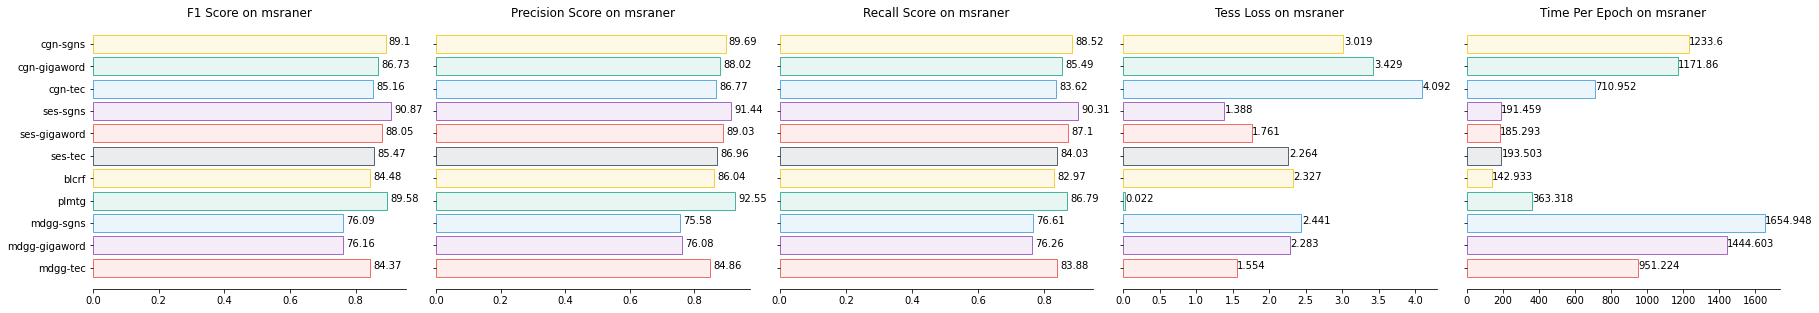

#1 Dataset: ecommerce


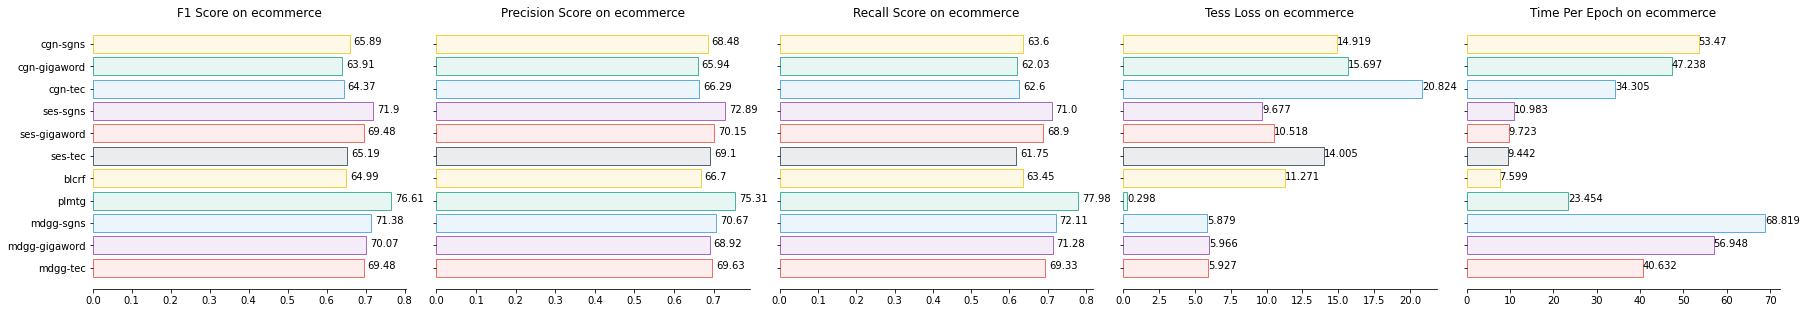

#2 Dataset: ontonotes


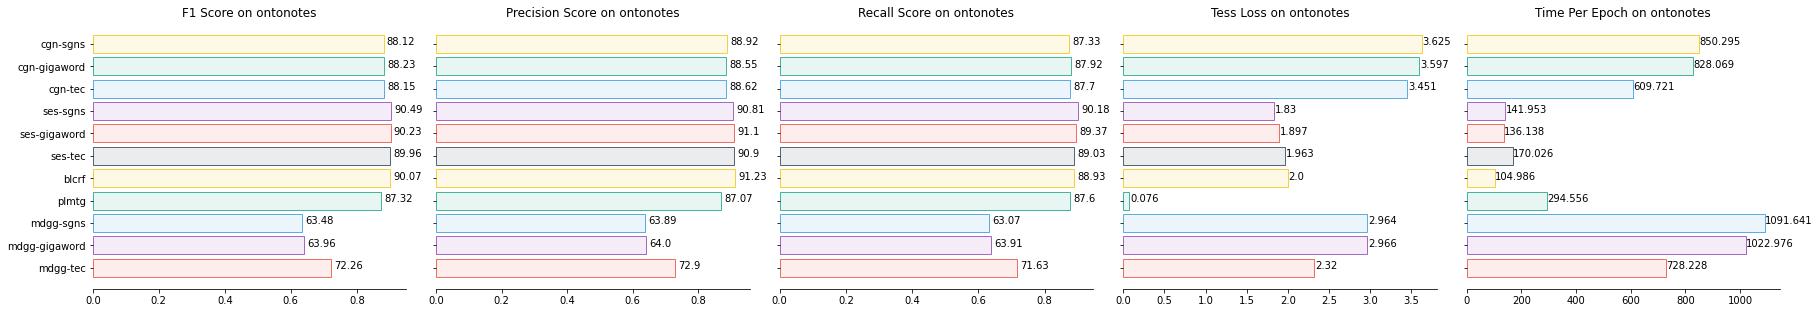

#3 Dataset: weiboner


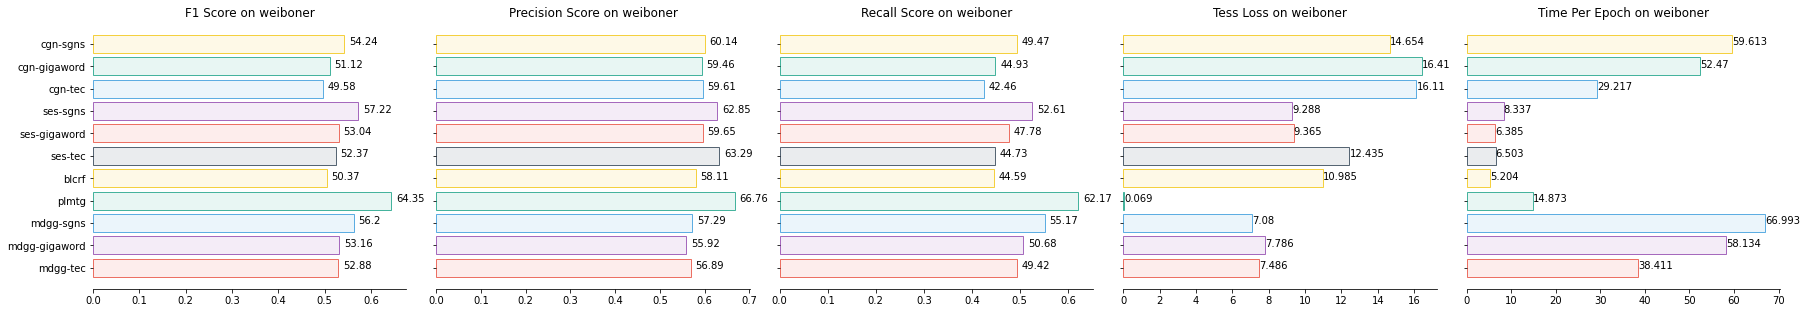

#4 Dataset: resumener


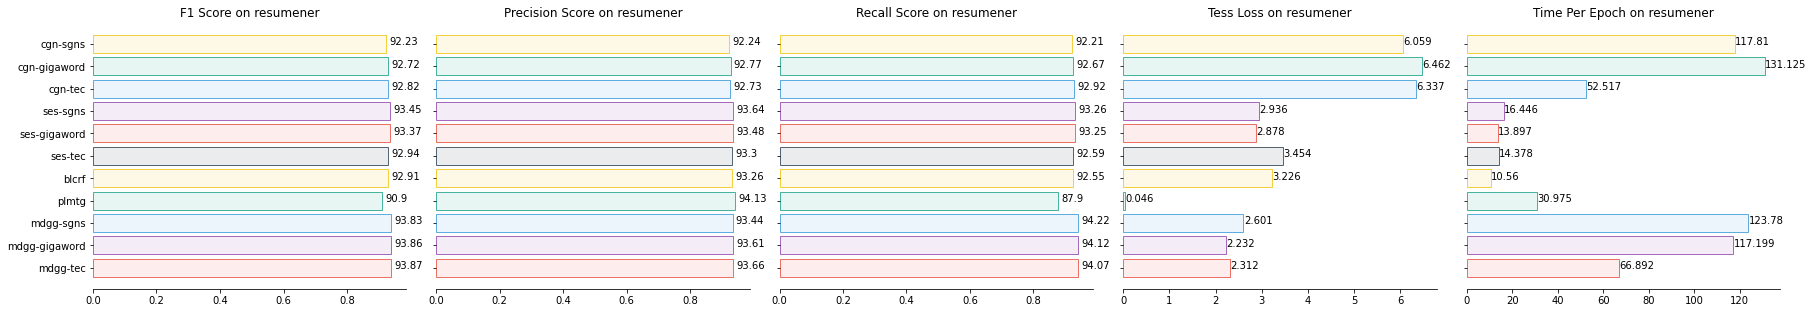

In [5]:
content_colors = ["#FDEDEC", "#F4ECF7", "#EBF5FB", "#E8F6F3", "#FEF9E7", "#EAECEE"]
edge_colors    = ["#EC7063", "#A569BD", "#5DADE2", "#45B39D", "#F4D03F", "#566573"]

# configuration
log_folder = "../data/logs/"
labpath = "../data/logs/experiments.csv"
tracker = NERTracker.load(labpath)
results = tracker.summay()
save_json(results, os.path.dirname(labpath), "experimental_summary.json")

reports = defaultdict(list)
for result in results:
    reports[result["dataset"]].append(result)
    
for i, (dataset, report) in enumerate(reports.items()):
    print("\x1b[6;30;42m#{0} Dataset: {1}\x1b[0m".format(i, dataset))
    x = ["{0}-{1}".format(r["model"], r["gazetteer_model"]) for _, r in enumerate(report)]
    for i, label in enumerate(x):
        if label.startswith(("blcrf", "plmtg")):
            x[i] = x[i].split("-")[0]
    fig, axs = plt.subplots(1, 5, sharey = True)
    fig.tight_layout(pad=0.05)
    fig.set_figwidth(25)
    # f1 score
    y = [r["f1_score"] for _, r in enumerate(report)]
    axs[0].barh(x, y, color=content_colors, edgecolor=edge_colors)
    axs[0].set_title("F1 Score on {0}".format(dataset))
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['left'].set_visible(False)
    for i, v in enumerate(y):
        axs[0].text(v + 0.01, i - 0.05, str(round(v*100, 2)))
    # precison score
    y = [r["precision_score"] for _, r in enumerate(report)]
    axs[1].barh(x, y, color=content_colors, edgecolor=edge_colors)
    axs[1].set_title("Precision Score on {0}".format(dataset))
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['left'].set_visible(False)
    for i, v in enumerate(y):
        axs[1].text(v + 0.01, i - 0.05, str(round(v*100, 2)))
    # recall score
    y = [r["recall_score"] for _, r in enumerate(report)]
    axs[2].barh(x, y, color=content_colors, edgecolor=edge_colors)
    axs[2].set_title("Recall Score on {0}".format(dataset))
    axs[2].spines['top'].set_visible(False)
    axs[2].spines['right'].set_visible(False)
    axs[2].spines['left'].set_visible(False)
    for i, v in enumerate(y):
        axs[2].text(v + 0.01, i - 0.05, str(round(v*100, 2)))
    # test loss
    y = [r["test_loss"] for _, r in enumerate(report)]
    axs[3].barh(x, y, color=content_colors, edgecolor=edge_colors)
    axs[3].set_title("Tess Loss on {0}".format(dataset))
    axs[3].spines['top'].set_visible(False)
    axs[3].spines['right'].set_visible(False)
    axs[3].spines['left'].set_visible(False)
    for i, v in enumerate(y):
        axs[3].text(v + 0.01, i - 0.05, str(round(v, 3)))
    # time per epoch
    y = [r["time_per_epoch"] for _, r in enumerate(report)]
    axs[4].barh(x, y, color=content_colors, edgecolor=edge_colors)
    axs[4].set_title("Time Per Epoch on {0}".format(dataset))
    axs[4].spines['top'].set_visible(False)
    axs[4].spines['right'].set_visible(False)
    axs[4].spines['left'].set_visible(False)
    for i, v in enumerate(y):
        axs[4].text(v + 0.01, i - 0.05, str(round(v, 3)))

    plt.show()
    fig.savefig(os.path.join(log_folder, "{0}_chart.pdf".format(dataset)))